In [133]:
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.use_deterministic_algorithms(True)

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [22]:
!kaggle datasets download -d pankrzysiu/keras-imdb

Dataset URL: https://www.kaggle.com/datasets/pankrzysiu/keras-imdb
License(s): other
 86% 113M/131M [00:01<00:00, 87.1MB/s] 
100% 131M/131M [00:01<00:00, 76.1MB/s]


In [23]:
import zipfile
zip_reff = zipfile.ZipFile('/content/keras-imdb.zip','r')
zip_reff.extractall('/content')
zip_reff.close()

In [134]:
df = pd.read_csv(r'/content/imdb-dataset-of-50k-movie-reviews.zip')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [135]:
df.isnull().sum()

,0
review,0
sentiment,0


In [136]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [29]:
review_list = []
label_list = []

for label in ['pos', 'neg']:
    for fname in tqdm(os.listdir(f'/content/aclImdb_v1/aclImdb/train/{label}/')):
        if 'txt' not in fname:
            continue
        with open(os.path.join(f'/content/aclImdb_v1/aclImdb/train/{label}/', fname), encoding='utf8') as f:
            review_list +=[f.read()]
            label_list += [label]
print('Number of reviews:', len(review_list))

100%|██████████| 12500/12500 [00:00<00:00, 45413.78it/s]

Number of reviews: 25000


In [32]:
# pre-processing review text
review_list = [review.lower() for review in review_list]
review_list = [''.join([letter for letter in review if letter not in punctuation]) for review in tqdm(review_list)]

# accumulate all review texts together
reviews_blob = ' '.join(review_list)

# generate list of all words of all reviews
review_words = reviews_blob.split()

# get the word counts
count_words = Counter(review_words)

# sort words as per counts (decreasing order)
total_review_words = len(review_words)
sorted_review_words = count_words.most_common(total_review_words)

print(total_review_words)
print(sorted_review_words[:10])

100%|██████████| 25000/25000 [00:01<00:00, 13694.22it/s]


5821814
[('the', 334691), ('and', 162228), ('a', 161940), ('of', 145326), ('to', 135042), ('is', 106855), ('in', 93028), ('it', 77099), ('i', 75719), ('this', 75190)]


In [34]:
# create word to integer (token) dictionary in order to encode text as numbers
vocab_to_token = {word:idx+1 for idx, (word, count) in enumerate(sorted_review_words)}
print(list(vocab_to_token.items())[:10])

[('the', 1), ('and', 2), ('a', 3), ('of', 4), ('to', 5), ('is', 6), ('in', 7), ('it', 8), ('i', 9), ('this', 10)]


In [38]:
reviews_tokenized = []
for review in review_list:
    word_to_token = [vocab_to_token[word] for word in review.split()]
    reviews_tokenized.append(word_to_token)
print(review_list[0])
print()
print(reviews_tokenized[0])


its very sly for all of the 60s look to the movie the humor is quite gentle but it grew on me much more than i expected the cast is firstrate and they appear to be having a wonderful time ustinov wanders through the film muttering some quite funny things under his breath and its all very inconsequential ill buy the movie as soon as it comes out on dvd the plot is that ustinov as an embezzler released from prison posing as a computer whiz and embezzling money from an american company with an office in london maggie smith is his secretary for a while and watching her get fired from many different jobs is part of the fun bob newhart is his usual deadpan self and karl malden has fun as the dense and sleazy executive running the london office the ending is funny and nicely cynical

[29, 52, 7307, 15, 31, 4, 1, 1708, 162, 5, 1, 17, 1, 481, 6, 175, 3725, 18, 8, 1988, 20, 69, 72, 51, 70, 9, 853, 1, 176, 6, 6906, 2, 34, 943, 5, 27, 251, 3, 373, 61, 5187, 6023, 140, 1, 19, 18993, 46, 175, 161, 1

In [70]:
encoded_label_list = [1 if label =='pos' else 0 for label in label_list]

reviews_len = [len(review) for review in reviews_tokenized]
reviews_tokenized = [reviews_tokenized[i] for i, l in enumerate(reviews_len) if l>0 ]
encoded_label_list = np.array([encoded_label_list[i] for i, l in enumerate(reviews_len) if l> 0 ], dtype='float32')

(array([1.7708e+04, 5.3030e+03, 1.3860e+03, 5.3200e+02, 5.6000e+01,
        8.0000e+00, 4.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  10. ,  255.9,  501.8,  747.7,  993.6, 1239.5, 1485.4, 1731.3,
        1977.2, 2223.1, 2469. ]),
 <BarContainer object of 10 artists>)

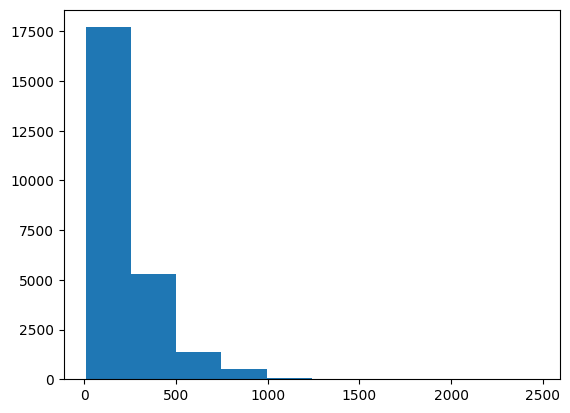

In [63]:
def pad_sequences(reviews_tokenized, sequence_length):
    ''' returns the tokenized review sequences padded with 0's or truncated to the sequence_length.
    '''
    padded_reviews = np.zeros((len(reviews_tokenized), sequence_length), dtype= int)

    for idx, review in enumerate(reviews_tokenized):
        review_len = len(review)

        if review_len <= sequence_length:
            zeroes = list(np.zeros(sequence_length - review_len))
            new_sequence = zeroes + review
        elif review_len > sequence_length:
            new_sequence = review[0 : sequence_length]

        padded_reviews[idx,:] = np.array(new_sequence)

    return padded_reviews

sequence_length = 512
padded_reviews = pad_sequences(reviews_tokenized, sequence_length)
plt.hist(reviews_len)

In [85]:
train_val_split = 0.75
train_x = padded_reviews[:int(train_val_split * len(padded_reviews))]
train_y = encoded_label_list[:int(train_val_split * len(padded_reviews))]
validation_x = padded_reviews[int(train_val_split * len(padded_reviews)):]
validation_y = encoded_label_list[int(train_val_split * len(padded_reviews)):]

In [88]:
#generate torch dataset

train_dataset = TensorDataset(torch.from_numpy(train_x).to(device), torch.from_numpy(train_y).to(device))
validation_dataset = TensorDataset(torch.from_numpy(validation_x).to(device), torch.from_numpy(validation_y).to(device))


batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
validation_dataloaderr = DataLoader(validation_dataset, batch_size = batch_size, shuffle = True)


In [90]:
train_data_iter = iter(train_dataloader)
X_example, y_example = next(train_data_iter)
print('Example Input size: ', X_example.size()) # batch_size, seq_length
print('Example Input:\n', X_example)
print()
print('Example Output size: ', y_example.size()) # batch_size
print('Example Output:\n', y_example)

Example Input size:  torch.Size([32, 512])
Example Input:
 tensor([[    0,     0,     0,  ...,     3,    49, 16286],
        [    0,     0,     0,  ...,   248,    97,   131],
        [    0,     0,     0,  ...,    24,   366,  2685],
        ...,
        [    0,     0,     0,  ...,     7,    10,  1166],
        [    0,     0,     0,  ...,    16,    10, 87124],
        [    0,     0,     0,  ...,     4,    29,   509]])

Example Output size:  torch.Size([32])
Example Output:
 tensor([0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
        1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.])


In [107]:
class RNN(nn.Module):

    def __init__(self, input_dimension, embedding_dimension, hiddem_dimension,output_dimension):
        super().__init__()
        self.embedding_layer = nn.Embedding(input_dimension, embedding_dimension)
        self.rnn_layer  = nn.RNN(embedding_dimension, hiddem_dimension, num_layers=1)
        self.fc_layer = nn.Linear(hiddem_dimension, output_dimension)

    def forward(self, sequence):
        # sequence shape = (sequence_length, batch_size)
        embedding = self.embedding_layer(sequence)
        # embedding shape = [sequence_length, batch_size, embedding_dimension]
        output, hidden_state = self.rnn_layer(embedding)
         # output shape = [sequence_length, batch_size, hidden_dimension]
        # hidden_state shape = [1, batch_size, hidden_dimension]
        final_output = self.fc_layer(hidden_state[-1,::].squeeze(0))
        return final_output


In [108]:
input_dimension = len(vocab_to_token) + 1 # +1 to account for padding
embedding_dimension = 100
hidden_dimension = 32
output_dimension = 1

rnn_model = RNN(input_dimension, embedding_dimension, hidden_dimension, output_dimension)


optim = torch.optim.Adam(rnn_model.parameters(), lr = 0.001)

loss_func = nn.BCEWithLogitsLoss()

rnn_model = rnn_model.to(device)
loss_func = loss_func.to(device)

In [109]:
def accuracy_predictions(predictions, ground_trurh):
    """
    Returns 0-1 accuracy for the given set of predictions and ground truth
    """
    # round predictions to either 0 or 1

    rounded_predictioins = torch.round(torch.sigmoid(predictions))
    success = (rounded_predictioins == ground_trurh).float()
    accuracy = success.sum() / len(success)
    return accuracy


In [110]:
def train(model, dataloader, optim, loss_func):
    loss = 0
    accuracy = 0
    model.train()

    for sequence, sentiment in dataloader:
        optim.zero_grad()
        preds = model(sequence.T).squeeze()

        loss_curr = loss_func(preds, sentiment)
        accuracy_curr = accuracy_predictions(preds, sentiment)

        loss_curr.backward()
        optim.step()

        loss +=loss_curr.item()
        accuracy += accuracy_curr.item()

    return loss/len(dataloader), accuracy/len(dataloader)

In [98]:
def validation(model, dataloader, loss_func):
    loss = 0
    accuracy = 0
    model.eval()

    with torch.no_grad():

        for sequence, sentiment in dataloader:
            preds = model(sequence.T).squeeze()

            loss_curr = loss_func(preds, sentiment)
            accuracy_curr = accuracy_predictions(preds, sentiment)

            loss += loss_curr.item()
            accuracy += accuracy_curr.item()

    return loss/len(dataloader), accuracy/len(dataloader)

In [111]:
num_epochs = 10
best_validation_loss = float('inf')

for ep in range(num_epochs):
    time_start = time.time()

    training_loss, train_accuracy = train(rnn_model, train_dataloader, optim, loss_func)
    validation_loss, validation_accuracy = validation(rnn_model, validation_dataloaderr, loss_func)

    time_end = time.time()
    time_delta = time_end - time_start

    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        torch.save(rnn_model.state_dict(), 'rnn_model.pt')

    print(f'epoch number: {ep+1} | time elapsed: {time_delta}s')
    print(f'training loss: {training_loss:.3f} | training accuracy: {train_accuracy*100:.2f}%')
    print(f'validation loss: {validation_loss:.3f} |  validation accuracy: {validation_accuracy*100:.2f}%')
    print()



epoch number: 1 | time elapsed: 58.81659531593323s
training loss: 0.619 | training accuracy: 67.34%
validation loss: 0.956 |  validation accuracy: 35.99%

epoch number: 2 | time elapsed: 57.95445513725281s
training loss: 0.538 | training accuracy: 73.66%
validation loss: 1.014 |  validation accuracy: 39.37%

epoch number: 3 | time elapsed: 58.92358875274658s
training loss: 0.450 | training accuracy: 79.81%
validation loss: 0.867 |  validation accuracy: 53.79%

epoch number: 4 | time elapsed: 60.264087438583374s
training loss: 0.403 | training accuracy: 82.59%
validation loss: 1.071 |  validation accuracy: 42.48%

epoch number: 5 | time elapsed: 57.192545652389526s
training loss: 0.341 | training accuracy: 85.87%
validation loss: 0.996 |  validation accuracy: 54.51%

epoch number: 6 | time elapsed: 59.54867100715637s
training loss: 0.264 | training accuracy: 89.95%
validation loss: 0.828 |  validation accuracy: 65.49%

epoch number: 7 | time elapsed: 63.03067231178284s
training loss: 0.

In [129]:
def sentiment_inference(model, sentence):
    model.eval()

    #Text Transformation
    sentence = sentence.lower()
    sentence = ''.join([c for c in sentence if c not in punctuation])
    tokenized = [vocab_to_token.get(token, 0) for token in sentence.split()]
    tokenized = np.pad(tokenized, (512 - len(tokenized),0),'constant')

    # Model inference
    model_input = torch.LongTensor(tokenized).to(device)
    model_input = model_input.unsqueeze(1)
    pred = torch.sigmoid(model(model_input))

    if pred.item() > 0.75:
        print(f'predicted score{pred.item()}','So its classified as Positive review')
    else:
        print(f'predicted score{pred.item()}','So its classified as Negative review')
    #

In [130]:
print(sentiment_inference(rnn_model, 'This is the worst film i ever watched in my life'))


predicted score0.15444506704807281 So its classified as Negative review
None


In [131]:
print(sentiment_inference(rnn_model, 'One of the best film i ever watched'))


predicted score0.9780964255332947 So its classified as Positive review
None


In [132]:
print(sentiment_inference(rnn_model, "This film is horrible"))
print(sentiment_inference(rnn_model, "Director tried too hard but this film is bad"))
print(sentiment_inference(rnn_model, "This film will be houseful for weeks"))
print(sentiment_inference(rnn_model, "I just really loved the movie"))

predicted score0.017410878092050552 So its classified as Negative review
None
predicted score0.38665199279785156 So its classified as Negative review
None
predicted score0.996425449848175 So its classified as Positive review
None
predicted score0.9821121692657471 So its classified as Positive review
None
